# Exploring Reversal in Crypto

Exploring optimization of the Directional Index Strategy. For more details, see project README.md!

In [2]:
from binance.client import Client as bnb_client
import statsmodels.api as sm
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# # Get all USDT trading pairs - Uncomment to download and save to pickle

# client = bnb_client(tld='US')

# def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
#     data = client.get_historical_klines(symbol,freq,start_ts)
#     columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
#     'num_trades','taker_base_volume','taker_quote_volume','ignore']

#     data = pd.DataFrame(data,columns = columns)
    
#     # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
#     data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     return data 
# # Fetch all trading pairs
# exchange_info = client.get_exchange_info()

# # Extract all symbols that end with "USDT"
# univ = [symbol['symbol'] for symbol in exchange_info['symbols'] if symbol['quoteAsset'] == 'USDT']

# freq = '1h' #technically a period
# px = {}
# vol = {}
# high = {}
# low = {}
# for x in univ:
#     data = get_binance_px(x,freq)
#     px[x] = data.set_index('open_time')['close']
#     vol[x] = data.set_index('open_time')['volume']
#     high[x] = data.set_index('open_time')['high']
#     low[x] = data.set_index('open_time')['low']


# px = pd.DataFrame(px).astype(float)
# px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))

# vol = pd.DataFrame(vol).astype(float)
# vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

# high = pd.DataFrame(high).astype(float)
# high = high.reindex(pd.date_range(high.index[0],high.index[-1],freq=freq))

# low = pd.DataFrame(low).astype(float)
# low = low.reindex(pd.date_range(low.index[0],low.index[-1],freq=freq))

# ret = px.pct_change()

# Save to pickle to avoid long download
# px.to_pickle('full_usdt_df_'+ freq+'_px.pkl')
# ret.to_pickle('full_usdt_df_'+ freq+'_ret.pkl')
# vol.to_pickle('full_usdt_df_'+ freq+'_vol.pkl')
# high.to_pickle('full_usdt_df_'+ freq+'_high.pkl')
# low.to_pickle('full_usdt_df_'+ freq+'_low.pkl')

In [4]:
# Load data
px = pd.read_pickle('full_usdt_df_1d_px.pkl') #change file based on frequency
ret = pd.read_pickle('full_usdt_df_1d_ret.pkl') #change file based on frequency
vol = pd.read_pickle('full_usdt_df_1d_vol.pkl') #change file based on frequency
high = pd.read_pickle('full_usdt_df_1d_high.pkl') #change file based on frequency
low = pd.read_pickle('full_usdt_df_1d_low.pkl') #change file based on frequency
ret = px.pct_change()

C:\Users\burnb\AppData\Local\Temp\ipykernel_8564\629247080.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [5]:
# Keep high price-volume coins for master security
price_vol = px.mean()*vol.mean()

threshold = 100_000
big_coins = price_vol[price_vol > threshold].index

ret_big = ret[big_coins]

In [6]:
# Create a returns object

class returns:

    """Returns object:
       
       Given a portfolio of signals (port) and percent returns of a security (ret), this will output common metrics and variables used in
       performance evaluation and analysis.

       The purify() method performs a linear regression and extracts the residual from that regression. Pass in the appropriate beta for
       your regression.
       """
    
    def __init__(self, port, ret):
        self.port = port
        self.ret = ret

    # Normalize portfolio, usually done before gen_returns()
    def norm(self):
        self.port = self.port.divide(self.port.abs().sum(1),0) # normalize rows

    # Calculate returns and evaluation metrics
    def gen_returns(self, tcost_bps=20, N_trades = 365, print_results=True):
        self.gross_ret = (self.port.shift()*self.ret).sum(1)
        self.to = (self.port - self.port.shift()).abs().sum(1)
        self.mean_tcost = self.to.mean()*tcost_bps*1e-4
        self.net_ret = self.gross_ret.subtract(self.to*tcost_bps*1e-4,fill_value=0)
        self.mean_gross = self.gross_ret.mean()
        
        if print_results:
            print("Mean gross returns:", self.mean_gross,
             "\nMean tcosts:", self.mean_tcost,
             "\nMean net returns:", self.net_ret.mean(),
             "\nGross Sharpe:", self.gross_ret.mean()/self.gross_ret.std()*np.sqrt(N_trades), 
             "\nNet Sharpe:", self.net_ret.mean()/self.net_ret.std()*np.sqrt(N_trades),
             "\nMean turnover:", self.to.mean())

    # Purify strategy: Does linear regression on chosen beta and outputs alpha and information ratio
    def purify(self, beta, N_trades = 365, print_results=True):
        Y = self.net_ret
        X = beta
        X = sm.add_constant(X)
        
        results = sm.OLS(Y, X).fit()
        self.alpha = results.params['const'] + results.resid
        self.ir = self.alpha.mean()/self.alpha.std()*np.sqrt(N_trades)
        
        if print_results:
            print("params:",
            '\n',results.params,
            "\nt-values:", 
            '\n',results.tvalues,
            '\nInfo Ratio:', self.ir)



In [7]:
# Define average functions

# Simple moving average
def sma(asset_df, avg_time):
    return asset_df.rolling(window=avg_time).mean()

# Exponential (weighted) moving average
def ema(asset_df, alpha):
    return asset_df.ewm(alpha=alpha, adjust=False).mean()   


## Try basket pairs trading
- When divergence in price is sufficiently large, trade.
    - Exit when divergence drops.
    - Use highly correlated coins

In [8]:
# Function to perform rolling regression

"""Can't use df.rolling(), only accepts scalar. Below is a multivariate multiple regression with a single coin as the 
independent variable and all other coins in the universe as dependent variables. Also finds correlation in rolling window
and only includes those coins."""

def rolling_regression(df, indep_var, window, corr_thresh=0.7):
    results = []
    consts = []
    
    # Manual rolling window regression
    for start in range(len(df) - window + 1):
        window_df = df.iloc[start:start + window]  
        X = window_df[indep_var].fillna(0)
        X = sm.add_constant(X)  
        Y = window_df.drop(columns=[indep_var]).fillna(0)
        corrs = window_df.corr().loc[indep_var].drop(indep_var)
        model = sm.OLS(Y, X).fit()
        beta_row = model.params.loc[indep_var].copy()   
        const_row = model.params.loc['const'].copy()     
        
        # For coins whose rolling correlation is below threshold, set regression outputs to 0
        for coin in beta_row.index:
            if abs(corrs.iloc[coin]) < corr_thresh:
                beta_row[coin] = 0   
                const_row[coin] = 0 
                
        results.append(beta_row)
        consts.append(const_row)
        
    betas = pd.DataFrame(results, index=df.index[window-1:])
    betas.columns = Y.columns
    consts = pd.DataFrame(consts, index=df.index[window-1:])
    consts.columns = Y.columns
    
    independent = df[indep_var].iloc[window:]
    dep_vars = df.drop(columns=[indep_var]).iloc[window:]
    
    return {'betas': betas, 'consts': consts, 'indep var':independent, 'dep vars':dep_vars}


In [9]:
# Pairs trade signal generation function

def pairs_trade(sec, basket, betas, threshold=1):

    # Calculate residual of basket and target sec and threshold reversal trades
    diff = basket - betas.multiply(sec,axis=0)
    pos_diff = diff > diff.rolling(100).std()*threshold
    neg_diff = diff < -1*diff.rolling(100).std()*threshold

    # Make df of longs (1's) and shorts (-1's)
    signal = pd.DataFrame(0,index=basket.index, columns=basket.columns)
    signal = signal.mask(pos_diff, -1).mask(neg_diff, 1)
    return signal


# Pairs trade function but smooths residual with EMA
def pairs_trade_smooth(sec, basket, betas, threshold=1, alpha = 0.5):

    # Calculate residual of basket and target sec and threshold reversal trades
    diff = ema(basket - betas.multiply(sec,axis=0), alpha)
    pos_diff = diff > diff.rolling(100).std()*threshold
    neg_diff = diff < -1*diff.rolling(100).std()*threshold

    # Make df of longs (1's) and shorts (-1's)
    signal = pd.DataFrame(0,index=basket.index, columns=basket.columns)
    signal = signal.mask(pos_diff, -1).mask(neg_diff, 1)
    return signal



In [9]:
# Do rolling reg. In separate cell because its a bit slow
window = 30
roll_reg = rolling_regression(ret.fillna(0), 'BTCUSDT', window)

Mean gross returns: 0.006035292421956031 
Mean tcosts: 0.002711049168208792 
Mean net returns: 0.0033664276287712347 
Gross Sharpe: 3.5925227952804453 
Net Sharpe: 2.026561257831838 
Mean turnover: 1.355524584104396
params: 
 const      0.003313
BTCUSDT    0.028985
dtype: float64 
t-values: 
 const      4.577384
BTCUSDT    1.351222
dtype: float64 
Info Ratio: 1.9951669446659632


<Axes: title={'center': 'Alpha: BTC Rolling Reg Pairs Trade'}>

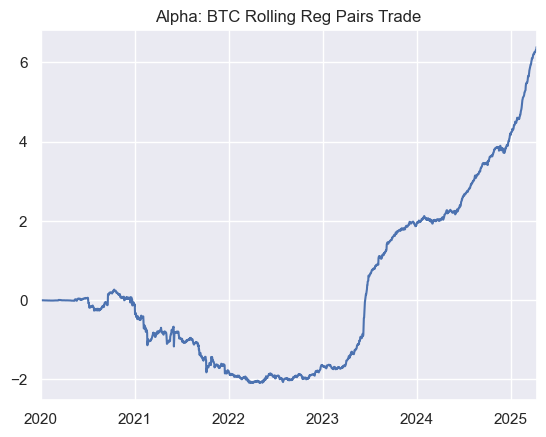

In [10]:
# Set up pairs trading example

ret = ret
sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

# Make signal
port = pairs_trade(sec,basket,betas,threshold=1.5)
port['BTCUSDT'] = -1*port.sum(1)  #add ind var back in, making dollar neutral

# Get results
rets = returns(port, ret)
rets.norm()
rets.gen_returns()

beta = ret['BTCUSDT'].fillna(0)
rets.purify(beta)

rets.alpha.cumsum().plot(title='Alpha: BTC Rolling Reg Pairs Trade')


## Implement Directional Index to Predict Reversal

In [11]:
# Directional index equations

def di_trend(high, low, close, alpha):

    # Positive directional movement
    pos_dm_condition = (high - high.shift(-1) > low.shift(-1) - low) & (high > high.shift(-1))
    pos_dm = (high - high.shift(-1)).where(pos_dm_condition, 0)

    # Negative directional movement
    neg_dm_condition = (high - high.shift(-1) < low.shift(-1) - low) & (low < low.shift(-1))
    neg_dm = (low.shift(-1) - low).where(neg_dm_condition, 0)

    # True Range
    hl = high - low
    hc = (high - close.shift(-1)).abs()
    cl = (close.shift(-1) - low).abs()   
    stacked = np.stack([hl.values, hc.values, cl.values], axis=0)
    tr = np.max(stacked, axis=0)
    tr = pd.DataFrame(tr, index=high.index, columns=high.columns)

    # Average directional index
    atr = ema(tr, alpha)
    pdi = ema(pos_dm, alpha)/atr
    ndi = ema(neg_dm, alpha)/atr

    di = (pdi-ndi).abs()/(pdi+ndi)
    di_sign = np.sign(pdi-ndi)

    return di, di_sign

In [12]:
# Make trend crossing functions

def trend_crossing(asset, fit, trend, threshold=0.3):
    
    diff = (asset - fit)/fit

    # Detect trend crossing with sign change and threshold on crossing strength and direction
    cross = diff.where(diff.shift()*diff < 0)
    cross = cross.where(trend.abs() >= threshold) 
    cross = cross.mask(cross > 0, 1).mask(cross < 0, -1)
    cross.ffill(inplace=True)  # Forward fill to maintain previous value
    
    return cross.fillna(0)


In [13]:
# Make training set

# Use high market cap coins for target security, but trade on all coins.
ret_train = ret.copy()
train_cols = ret_train.columns
high_train = high[train_cols]
low_train = low[train_cols]
close_train = px[train_cols]
master_sec_train = ret_big.columns[np.random.randint(0,ret_big.shape[1])] #Choose random big cap



Mean gross returns: 0.001667441918465175 
Mean tcosts: 0.00020436042195910004 
Mean net returns: 0.0014662613785905011 
Gross Sharpe: 2.703885796451049 
Net Sharpe: 2.421775371525869 
Mean turnover: 0.10218021097955
params: 
 const      0.001465
BTCUSDT    0.000716
dtype: float64 
t-values: 
 const      5.551108
BTCUSDT    0.091521
dtype: float64 
Info Ratio: 2.4195891865657932


<Axes: title={'center': 'Alpha: Directional Index Signal'}>

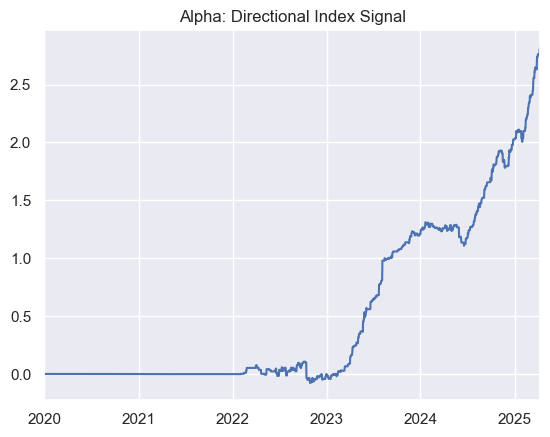

In [14]:
# Reversal Strategy
master_sec_train='BTCUSDT'
window = 30
roll_reg = rolling_regression(ret_train, master_sec_train, window)

alpha = 0.35 
di = di_trend(high_train, low_train, close_train, alpha)

# M/R sig threshold
thresh = 1/4
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

# Reversal components
sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

# Reversal signal
rev_port = pairs_trade(sec, basket, betas, threshold=1.5)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec_train] = -1*rev_port.sum(1)

rets = returns(rev_port, ret_train)
rets.norm()
rets.gen_returns()

beta = ret[master_sec_train].fillna(0)
rets.purify(beta)

rets.alpha.cumsum().plot(title='Alpha: Directional Index Signal')


## Slow down reversal signal

Compare with smoothed residual

Mean gross returns: 0.00133025220790586 
Mean tcosts: 0.00012957487165164935 
Mean net returns: 0.0012026935427633127 
Gross Sharpe: 2.6517539089935345 
Net Sharpe: 2.426951036465687 
Mean turnover: 0.06478743582582466
params: 
 const      0.001196
BTCUSDT    0.003427
dtype: float64 
t-values: 
 const      5.539005
BTCUSDT    0.535308
dtype: float64 
Info Ratio: 2.4143137746728383


<Axes: title={'center': 'Alpha: Directional Index Signal'}>

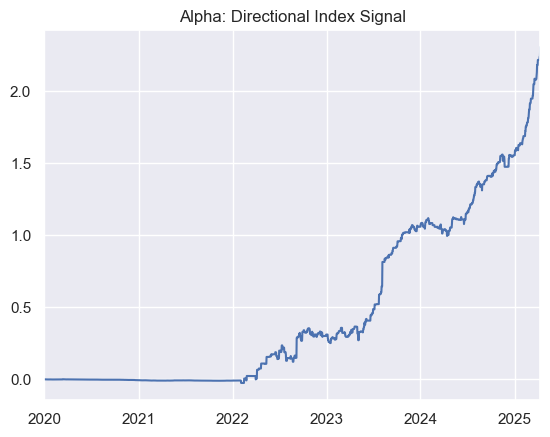

In [15]:
# Reversal Strategy - smoothed
window = 30
roll_reg = rolling_regression(ret_train, master_sec_train, window)

alpha = 0.35 
di = di_trend(high_train, low_train, close_train, alpha)

# M/R sig threshold
thresh = 1/4
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5, alpha = 0.2)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec_train] = -1*rev_port.sum(1)

rets = returns(rev_port, ret)
rets.norm()
rets.gen_returns()

beta = ret[master_sec_train].fillna(0)
rets.purify(beta)

rets.alpha.cumsum().plot(title='Alpha: Directional Index Signal')


## Reversal on all master coins

In [16]:
# # Explore performance on remaining data set using othe master coins

## UNCOMMENT TO RUN - LONG RUN TIME

# #### Reversal ####

# window = 30

# # Make trend signal
# alpha = 0.35 #often 1/(day average), can be optimized
# di = di_trend(high_train,low_train,close_train,alpha)

# info_rats = []

# # M/R sig threshold
# thresh = 0.3
# mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
# sig_thresh = np.max(mr_sig)*thresh

# for col in ret_big.columns:
#     roll_reg = rolling_regression(ret_train, col, window)

#     # Reversal components
#     sec = roll_reg['indep var']
#     betas = roll_reg['betas']
#     basket = roll_reg['dep vars']

#     # Reversal signal
#     rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5)
#     rev_port = rev_port.where(mr_sig > sig_thresh, 0)
#     rev_port[master_sec] = -1*rev_port.sum(1)

#     rets = returns(rev_port, ret_train)
#     rets.norm()
#     rets.gen_returns(print_results=False)
#     beta = ret_train[master_sec].fillna(0)
#     rets.purify(beta, print_results=False)
#     info_rats.append(rets.ir)


# # rets.alpha.cumsum().plot(title='Alpha: Reversal Strategy')
# # ret_train[master_sec].cumsum().plot()

In [17]:
# irs = pd.Series(info_rats, index=ret_big.columns)
# irs.plot(kind='bar', title = "Information Ratio for Master Coins", 
#          label = f"Mean IR: {irs.mean():.2f}")
# plt.legend()

## Apply to BTC

Mean gross returns: 0.00099852302186705 
Mean tcosts: 0.00017470834306322305 
Mean net returns: 0.0008265331696191262 
Gross Sharpe: 2.673465966068979 
Net Sharpe: 2.3030271916924927 
Mean turnover: 0.043677085765805757
params: 
 const      0.000809
BTCUSDT    0.009329
dtype: float64 
t-values: 
 const      5.178606
BTCUSDT    2.014073
dtype: float64 
Info Ratio: 2.2572247836628074


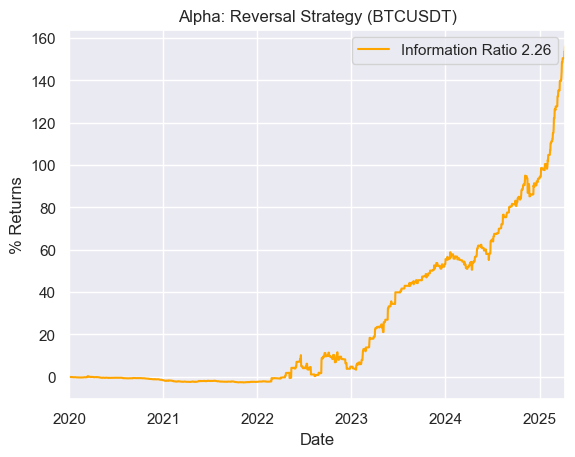

In [19]:
# Reversal Strategy on BTCUSDT - smoothed

master_sec = 'BTCUSDT'
close = px
window = 30
roll_reg = rolling_regression(ret, master_sec, window)

alpha = 0.35 
di = di_trend(high, low, close, alpha)

# M/R sig threshold
thresh = 0.3
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec] = -1*rev_port.sum(1)

rets = returns(rev_port, ret)
rets.norm()
rets.gen_returns(tcost_bps = 40)

beta = ret[master_sec].fillna(0)
rets.purify(beta)


(rets.alpha*100).cumsum().plot(title= f'Alpha: Reversal Strategy ({master_sec})', xlabel='Date', ylabel= '% Returns',
                              label = f"Information Ratio {rets.ir:.2f}", color = 'orange')
plt.legend()
plt.savefig('Reversal strat')

## Gating on Volume

Mean gross returns: 0.007330091045436204 
Mean tcosts: 0.000859705949624218 
Mean net returns: 0.006483762263077924 
Gross Sharpe: 4.367872053901094 
Net Sharpe: 3.8859272741440596 
Mean turnover: 0.859705949624218
params: 
 const      0.006423
BTCUSDT    0.032977
dtype: float64 
t-values: 
 const      8.836563
BTCUSDT    1.530770
dtype: float64 
Info Ratio: 3.851636575756635


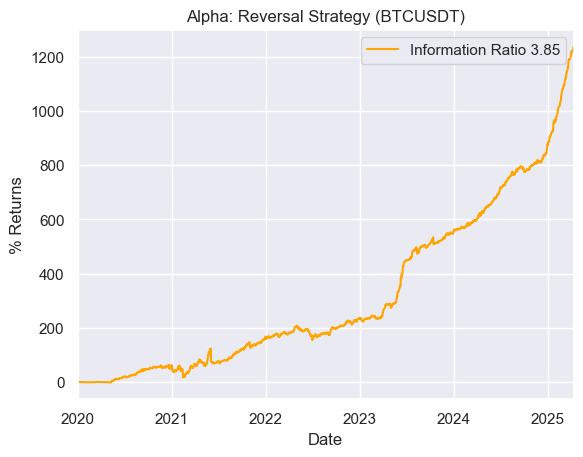

In [25]:
# Reversal Strategy on BTCUSDT - smoothed

master_sec = 'BTCUSDT'
close = px

window = 30
# roll_reg = rolling_regression(ret, master_sec, window)

alpha = 1/14 
di = di_trend(high, low, close, alpha)

sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

#Gate signal by volume and DI metric
rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5)
rev_port = rev_port.where(di[0] < .4, 0).where(vol > 1000, 0) 
rev_port1 = rev_port.copy()
rev_port[master_sec] = -1*rev_port.sum(1)

rets = returns(rev_port, ret)
rets.norm()
rets.gen_returns(tcost_bps=10) #Assume no slippage + Market Taking

beta = ret[master_sec].fillna(0)
rets.purify(beta)


(rets.alpha*100).cumsum().plot(title= f'Alpha: Reversal Strategy ({master_sec})', xlabel='Date', ylabel= '% Returns',
                              label = f"Information Ratio {rets.ir:.2f}", color = 'orange')
plt.legend()
# plt.savefig('Reversal strat')


In [31]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict

# def analyze_streaks(df, value_column):
#     """
#     Analyze positive and negative streaks in a time series.
    
#     Parameters:
#     df: pandas DataFrame with time-series index
#     value_column: string, name of the column containing values
    
#     Returns:
#     dict with positive_streaks and negative_streaks lists
#     """
#     values = df[value_column].values
    
#     positive_streaks = []
#     negative_streaks = []
    
#     current_streak = 0
#     current_sign = None
    
#     for value in values:
#         if value > 0:  # Positive value
#             if current_sign == 'positive':
#                 current_streak += 1
#             else:
#                 # End previous streak if it exists
#                 if current_sign == 'negative' and current_streak > 0:
#                     negative_streaks.append(current_streak)
#                 # Start new positive streak
#                 current_streak = 1
#                 current_sign = 'positive'
                
#         elif value < 0:  # Negative value
#             if current_sign == 'negative':
#                 current_streak += 1
#             else:
#                 # End previous streak if it exists
#                 if current_sign == 'positive' and current_streak > 0:
#                     positive_streaks.append(current_streak)
#                 # Start new negative streak
#                 current_streak = 1
#                 current_sign = 'negative'
                
#         else:  # Zero value - breaks any streak
#             if current_sign == 'positive' and current_streak > 0:
#                 positive_streaks.append(current_streak)
#             elif current_sign == 'negative' and current_streak > 0:
#                 negative_streaks.append(current_streak)
#             current_streak = 0
#             current_sign = None
    
#     # Don't forget the last streak
#     if current_sign == 'positive' and current_streak > 0:
#         positive_streaks.append(current_streak)
#     elif current_sign == 'negative' and current_streak > 0:
#         negative_streaks.append(current_streak)
    
#     return {
#         'positive_streaks': positive_streaks,
#         'negative_streaks': negative_streaks
#     }

# def plot_streak_histograms(streak_data, title="Streak Length Distribution"):
#     """
#     Plot histograms of positive and negative streak lengths.
#     """
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
#     # Positive streaks histogram
#     if streak_data['positive_streaks']:
#         ax1.hist(streak_data['positive_streaks'], bins=range(1, max(streak_data['positive_streaks'])+2), 
#                 alpha=0.7, color='green', edgecolor='black')
#         ax1.set_title('Positive Streak Lengths')
#         ax1.set_xlabel('Streak Length (periods)')
#         ax1.set_ylabel('Frequency')
#         ax1.grid(True, alpha=0.3)
#     else:
#         ax1.text(0.5, 0.5, 'No positive streaks', ha='center', va='center', transform=ax1.transAxes)
#         ax1.set_title('Positive Streak Lengths')
    
#     # Negative streaks histogram
#     if streak_data['negative_streaks']:
#         ax2.hist(streak_data['negative_streaks'], bins=range(1, max(streak_data['negative_streaks'])+2), 
#                 alpha=0.7, color='red', edgecolor='black')
#         ax2.set_title('Negative Streak Lengths')
#         ax2.set_xlabel('Streak Length (periods)')
#         ax2.set_ylabel('Frequency')
#         ax2.grid(True, alpha=0.3)
#     else:
#         ax2.text(0.5, 0.5, 'No negative streaks', ha='center', va='center', transform=ax2.transAxes)
#         ax2.set_title('Negative Streak Lengths')
    
#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()

# def print_streak_summary(streak_data):
#     """
#     Print summary statistics of streaks.
#     """
#     pos_streaks = streak_data['positive_streaks']
#     neg_streaks = streak_data['negative_streaks']
    
#     print("=== STREAK ANALYSIS SUMMARY ===")
#     print(f"\nPositive Streaks:")
#     if pos_streaks:
#         print(f"  Count: {len(pos_streaks)}")
#         print(f"  Average length: {np.mean(pos_streaks):.2f} periods")
#         print(f"  Median length: {np.median(pos_streaks):.1f} periods")
#         print(f"  Longest streak: {max(pos_streaks)} periods")
#         print(f"  Shortest streak: {min(pos_streaks)} periods")
#     else:
#         print("  No positive streaks found")
    
#     print(f"\nNegative Streaks:")
#     if neg_streaks:
#         print(f"  Count: {len(neg_streaks)}")
#         print(f"  Average length: {np.mean(neg_streaks):.2f} periods")
#         print(f"  Median length: {np.median(neg_streaks):.1f} periods")
#         print(f"  Longest streak: {max(neg_streaks)} periods")
#         print(f"  Shortest streak: {min(neg_streaks)} periods")
#     else:
#         print("  No negative streaks found")


Sample data (first 10 rows):
               value
date                
2020-01-01 -0.210971
2020-01-02  0.148127
2020-01-03  0.834781
2020-01-04  2.128030
2020-01-05  2.214372
2020-01-06  2.262903
2020-01-07  4.583184
2020-01-08  4.494814
2020-01-09  4.066826
2020-01-10  4.443388

Data shape: (100, 1)
Value range: -12.66 to 4.58


In [41]:

# # Analyze streaks
# streak_results = analyze_streaks(rev_port, master_sec)

# # Get summary and plots
# print_streak_summary(streak_results)
# plot_streak_histograms(streak_results, "Your Data Title")

In [42]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict

# def analyze_streaks(df, value_columns=None):
#     """
#     Analyze positive and negative streaks in a time series for all numeric columns.
    
#     Parameters:
#     df: pandas DataFrame with time-series index
#     value_columns: list of column names to analyze, or None to analyze all numeric columns
    
#     Returns:
#     dict with column names as keys, each containing positive_streaks and negative_streaks lists
#     """
#     if value_columns is None:
#         # Get all numeric columns
#         value_columns = df.select_dtypes(include=[np.number]).columns.tolist()
#     elif isinstance(value_columns, str):
#         # Handle single column passed as string
#         value_columns = [value_columns]
    
#     results = {}
    
#     for column in value_columns:
#         values = df[column].values
        
#         positive_streaks = []
#         negative_streaks = []
        
#         current_streak = 0
#         current_sign = None
        
#         for value in values:
#             # Skip NaN values
#             if pd.isna(value):
#                 # NaN breaks streaks
#                 if current_sign == 'positive' and current_streak > 0:
#                     positive_streaks.append(current_streak)
#                 elif current_sign == 'negative' and current_streak > 0:
#                     negative_streaks.append(current_streak)
#                 current_streak = 0
#                 current_sign = None
#                 continue
                
#             if value > 0:  # Positive value
#                 if current_sign == 'positive':
#                     current_streak += 1
#                 else:
#                     # End previous streak if it exists
#                     if current_sign == 'negative' and current_streak > 0:
#                         negative_streaks.append(current_streak)
#                     # Start new positive streak
#                     current_streak = 1
#                     current_sign = 'positive'
                    
#             elif value < 0:  # Negative value
#                 if current_sign == 'negative':
#                     current_streak += 1
#                 else:
#                     # End previous streak if it exists
#                     if current_sign == 'positive' and current_streak > 0:
#                         positive_streaks.append(current_streak)
#                     # Start new negative streak
#                     current_streak = 1
#                     current_sign = 'negative'
                    
#             else:  # Zero value - breaks any streak
#                 if current_sign == 'positive' and current_streak > 0:
#                     positive_streaks.append(current_streak)
#                 elif current_sign == 'negative' and current_streak > 0:
#                     negative_streaks.append(current_streak)
#                 current_streak = 0
#                 current_sign = None
        
#         # Don't forget the last streak
#         if current_sign == 'positive' and current_streak > 0:
#             positive_streaks.append(current_streak)
#         elif current_sign == 'negative' and current_streak > 0:
#             negative_streaks.append(current_streak)
        
#         results[column] = {
#             'positive_streaks': positive_streaks,
#             'negative_streaks': negative_streaks
#         }
    
#     return results

# def plot_streak_histograms(streak_data, title="Streak Length Distribution"):
#     """
#     Plot histograms of positive and negative streak lengths for all columns.
#     """
#     columns = list(streak_data.keys())
#     n_cols = len(columns)
    
#     if n_cols == 0:
#         print("No data to plot")
#         return
    
#     # Calculate subplot layout
#     if n_cols == 1:
#         fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#         axes = [axes]  # Make it a list for consistency
#     else:
#         n_rows = (n_cols + 1) // 2  # Round up division
#         fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
#         if n_rows == 1:
#             axes = [axes]  # Make it 2D for consistency
#         axes = axes.flatten() if n_cols > 2 else [axes]
    
#     plot_idx = 0
    
#     for col_idx, column in enumerate(columns):
#         data = streak_data[column]
        
#         # Create subplot for this column's positive and negative streaks
#         row_start = col_idx * 2
        
#         # Positive streaks
#         if plot_idx < len(axes):
#             ax_pos = axes[plot_idx] if n_cols > 1 else axes[0]
#             if data['positive_streaks']:
#                 ax_pos.hist(data['positive_streaks'], 
#                            bins=range(1, max(data['positive_streaks'])+2), 
#                            alpha=0.7, color='green', edgecolor='black')
#                 ax_pos.set_title(f'{column} - Positive Streaks')
#                 ax_pos.set_xlabel('Streak Length (periods)')
#                 ax_pos.set_ylabel('Frequency')
#                 ax_pos.grid(True, alpha=0.3)
#             else:
#                 ax_pos.text(0.5, 0.5, 'No positive streaks', ha='center', va='center', transform=ax_pos.transAxes)
#                 ax_pos.set_title(f'{column} - Positive Streaks')
#             plot_idx += 1
        
#         # Negative streaks
#         if plot_idx < len(axes):
#             ax_neg = axes[plot_idx] if n_cols > 1 else axes[1]
#             if data['negative_streaks']:
#                 ax_neg.hist(data['negative_streaks'], 
#                            bins=range(1, max(data['negative_streaks'])+2), 
#                            alpha=0.7, color='red', edgecolor='black')
#                 ax_neg.set_title(f'{column} - Negative Streaks')
#                 ax_neg.set_xlabel('Streak Length (periods)')
#                 ax_neg.set_ylabel('Frequency')
#                 ax_neg.grid(True, alpha=0.3)
#             else:
#                 ax_neg.text(0.5, 0.5, 'No negative streaks', ha='center', va='center', transform=ax_neg.transAxes)
#                 ax_neg.set_title(f'{column} - Negative Streaks')
#             plot_idx += 1
    
#     # Hide any unused subplots
#     for idx in range(plot_idx, len(axes)):
#         axes[idx].set_visible(False)
    
#     plt.suptitle(title, fontsize=16, y=0.98)
#     plt.tight_layout()
#     plt.show()

# def print_streak_summary(streak_data):
#     """
#     Print summary statistics of streaks for all columns.
#     """
#     print("=== STREAK ANALYSIS SUMMARY ===")
    
#     for column, data in streak_data.items():
#         print(f"\n📊 COLUMN: {column}")
#         print("=" * (len(column) + 12))
        
#         pos_streaks = data['positive_streaks']
#         neg_streaks = data['negative_streaks']
        
#         print(f"\nPositive Streaks:")
#         if pos_streaks:
#             print(f"  Count: {len(pos_streaks)}")
#             print(f"  Average length: {np.mean(pos_streaks):.2f} periods")
#             print(f"  Median length: {np.median(pos_streaks):.1f} periods")
#             print(f"  Longest streak: {max(pos_streaks)} periods")
#             print(f"  Shortest streak: {min(pos_streaks)} periods")
#             print(f"  Total periods: {sum(pos_streaks)} periods")
#         else:
#             print("  No positive streaks found")
        
#         print(f"\nNegative Streaks:")
#         if neg_streaks:
#             print(f"  Count: {len(neg_streaks)}")
#             print(f"  Average length: {np.mean(neg_streaks):.2f} periods")
#             print(f"  Median length: {np.median(neg_streaks):.1f} periods")
#             print(f"  Longest streak: {max(neg_streaks)} periods")
#             print(f"  Shortest streak: {min(neg_streaks)} periods")
#             print(f"  Total periods: {sum(neg_streaks)} periods")
#         else:
#             print("  No negative streaks found")

# def get_overall_summary(streak_data):
#     """
#     Get aggregated summary across all columns.
#     """
#     all_pos_streaks = []
#     all_neg_streaks = []
    
#     for column, data in streak_data.items():
#         all_pos_streaks.extend(data['positive_streaks'])
#         all_neg_streaks.extend(data['negative_streaks'])
    
#     print("\n" + "="*50)
#     print("🌍 OVERALL SUMMARY (All Columns Combined)")
#     print("="*50)
    
#     print(f"\nPositive Streaks (All Columns):")
#     if all_pos_streaks:
#         print(f"  Total count: {len(all_pos_streaks)}")
#         print(f"  Average length: {np.mean(all_pos_streaks):.2f} periods")
#         print(f"  Median length: {np.median(all_pos_streaks):.1f} periods")
#         print(f"  Longest streak: {max(all_pos_streaks)} periods")
#         print(f"  Shortest streak: {min(all_pos_streaks)} periods")
#     else:
#         print("  No positive streaks found across all columns")
    
#     print(f"\nNegative Streaks (All Columns):")
#     if all_neg_streaks:
#         print(f"  Total count: {len(all_neg_streaks)}")
#         print(f"  Average length: {np.mean(all_neg_streaks):.2f} periods")
#         print(f"  Median length: {np.median(all_neg_streaks):.1f} periods")
#         print(f"  Longest streak: {max(all_neg_streaks)} periods")
#         print(f"  Shortest streak: {min(all_neg_streaks)} periods")
#     else:
#         print("  No negative streaks found across all columns")



In [40]:
# # Analyze streaks
# streak_results = analyze_streaks(rev_port)

# # Get summary and plots
# print_streak_summary(streak_results)
# plot_streak_histograms(streak_results, "Your Data Title")